#  Modeling Coffee Reviewing with Linear Regression
### Will Rodman - Final Project - Math 6040 Linear Models

This project studies data from [coffeereviews.com](www.coffeereviews.com), which was obtained through web scraping and published on [kaggle.com](www.kaggle.com). The goal is to develop a linear regression model that predicts individual ratings for coffee beans. Additonal quesitons answered about the data include: 

- What features of a coffee mean determine best a ratings? 
- Are there types of coffee beans with different tiers of ratings? 
- How well can a linear model be fit to predict coffee bean ratings? 

Data source: [Link](https://www.kaggle.com/datasets/hanifalirsyad/coffee-scrap-coffeereview/versions/2/data?select=coffee_df.csv)

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import scipy.stats as stats

import statsmodels.api as sm

#### Sprint 1: Loading and cleaning the dataset. 

The CSV files [coffee_df](./data/coffee_df.csv) and [coffee_analysis](./data/coffee_analysis.csv) are two different versions of the data that has been scraped. In order to use feature from both datasets, I merge the two datasets and drop the duplicate values.

In [2]:
coffee_columns = ['acid', 'body', 'flavor', 'aftertaste', 'desc_1']
analysis_columns = ['roaster', 'roast', 'loc_country', '100g_USD', 'rating', 'desc_1']

coffee_df = pd.read_csv('data/coffee_df.csv', usecols=coffee_columns)
analysis_df = pd.read_csv('data/coffee_analysis.csv', usecols=analysis_columns)

df = pd.merge(coffee_df, analysis_df, on='desc_1', how='inner')

df.drop(['desc_1'], axis=1, inplace=True)
df.dropna(inplace=True)

dtypes = {
    'acid': int,
    'body': int,
    'flavor': int,
    'aftertaste': int,
    'roaster': 'category',
    'roast': 'category',
    'loc_country': 'category',
    '100g_USD': float,
    'rating': int,
}

df = df.astype(dtypes)

In [3]:
print("Dimensions", df.shape)
print('Data Types: \n', df.dtypes)
df.head(10)

Dimensions (1779, 9)
Data Types: 
 acid              int64
body              int64
flavor            int64
aftertaste        int64
roaster        category
roast          category
loc_country    category
100g_USD        float64
rating            int64
dtype: object


,acid,body,flavor,aftertaste,roaster,roast,loc_country,100g_USD,rating
0,9,9,9,8,Equator Coffees,Medium-Light,United States,12.93,94
1,9,9,9,8,Wonderstate Coffee,Medium-Light,United States,6.17,93
2,9,8,9,8,Bird Rock Coffee Roasters,Medium-Light,United States,5.58,92
3,8,8,9,8,Chromatic Coffee,Medium-Light,United States,9.17,92
4,8,9,9,8,GK Coffee,Medium-Light,Taiwan,8.80,92
5,8,8,9,8,Small Eyes Cafe,Light,Taiwan,6.08,92
6,9,8,9,7,Speckled Ax,Medium-Light,United States,5.88,91
7,9,8,9,7,Tico Coffee Roasters,Medium-Light,United States,5.88,91
8,9,9,9,9,Magnolia Coffee,Light,United States,13.23,95
9,9,9,9,8,Bird Rock Coffee Roasters,Light,United States,8.11,94


Since the `roast` feature is an ordinal categorical data type, this feature needs to be cartegoicaly encoded. 

Code table for the `roast` feature: 
| Roast       | Code |
|-------------|------|
| Light        | 0   |
| Medium-Light | 1   |
| Medium       | 2   |
| Medium-Dark  | 3   |
| Dark         | 4   |


In [4]:
# Remove ".codes" if you want to keep the name values.
roast_types = ['Light', 'Medium-Light', 'Medium', 'Medium-Dark', 'Dark']
df['roast'] = pd.Categorical(df['roast'], categories=roast_types, ordered=True).codes

In [5]:
df['body'].value_counts()

9     1145
8      620
7       13
10       1
Name: body, dtype: int64

#### Sprint 2: Analysis of features inside the dataset. 

Now that the dataset is clean, all the features in the dataset can be analyzed. This analysis will determine which features can be used in the linear regression model. Specifically for ordinal values, I will compute the Pearson correlation and a distribution test.



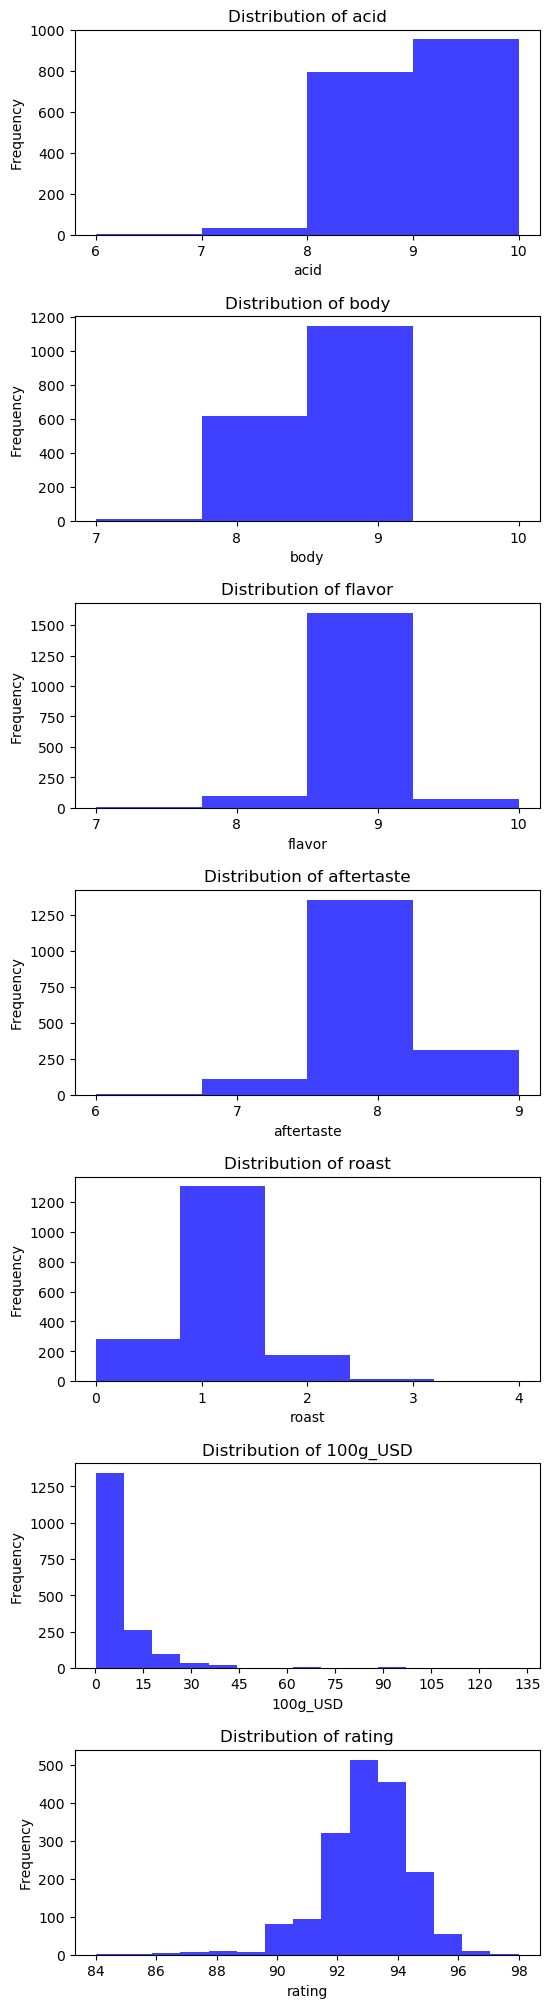

In [6]:
ordinal_features = ['acid', 'body', 'flavor', 'aftertaste', 'roast', '100g_USD', 'rating']
features_bins = [4, 4, 4, 4, 5, 15, 15]

fig, axs = plt.subplots(nrows=7, ncols=1, figsize=(6, 25))
fig.subplots_adjust(hspace=0.4)

for i, column in enumerate(ordinal_features):
    axs[i].hist(df[column], bins=features_bins[i], color='blue', alpha=0.75)
    axs[i].xaxis.set_major_locator(MaxNLocator(integer=True))

    axs[i].set_title(f'Distribution of {column}')
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlabel(column)


Looking at the plots of the distribution for the ordinal features, they do not appear to be normally distributed. I will test for normality by using the Shapiro-Wilk test.

In [7]:
for column in ordinal_features:
    stat, p = stats.shapiro(df[column])
    print(f"{column:12s}     stat: {stat:.3f}     p-value: {p:.3e}")


acid             stat: 0.699     p-value: 0.000e+00
body             stat: 0.632     p-value: 0.000e+00
flavor           stat: 0.427     p-value: 0.000e+00
aftertaste       stat: 0.649     p-value: 0.000e+00
roast            stat: 0.695     p-value: 0.000e+00
100g_USD         stat: 0.485     p-value: 0.000e+00
rating           stat: 0.920     p-value: 1.091e-29


Looking at the results of the Shapiro-Wilk test, none of the features are from a normal distribution.

In [8]:
df[ordinal_features].corr()

,acid,body,flavor,aftertaste,roast,100g_USD,rating
acid,1.000000,0.303699,0.373901,0.450708,-0.284833,0.178089,0.758571
body,0.303699,1.000000,0.304462,0.312396,-0.170706,0.174092,0.651938
flavor,0.373901,0.304462,1.000000,0.392868,-0.166842,0.234329,0.669822
aftertaste,0.450708,0.312396,0.392868,1.000000,-0.214959,0.250361,0.722725
roast,-0.284833,-0.170706,-0.166842,-0.214959,1.000000,-0.087101,-0.315501
100g_USD,0.178089,0.174092,0.234329,0.250361,-0.087101,1.000000,0.280223
rating,0.758571,0.651938,0.669822,0.722725,-0.315501,0.280223,1.000000


Partial correlation when conditioning on rating.

In [12]:
residuals_df = pd.DataFrame(index=df.index)

for feature in ordinal_features:
    X = sm.add_constant(df['rating'])
    model = sm.OLS(df[feature], X).fit()
    residuals_df[feature] = model.resid

residuals_df.corr()

,acid,body,flavor,aftertaste,roast,100g_USD,rating
acid,1.000000,-0.386256,-0.277391,-0.216573,-0.073593,-0.055126,-0.061837
body,-0.386256,1.000000,-0.234835,-0.302966,0.048615,-0.011810,-0.047665
flavor,-0.277391,-0.234835,1.000000,-0.177771,0.063139,0.065419,0.047664
aftertaste,-0.216573,-0.302966,-0.177771,1.000000,0.019915,0.072104,0.114956
roast,-0.073593,0.048615,0.063139,0.019915,1.000000,0.001438,0.008228
100g_USD,-0.055126,-0.011810,0.065419,0.072104,0.001438,1.000000,0.013544
rating,-0.061837,-0.047665,0.047664,0.114956,0.008228,0.013544,1.000000
